In [1]:
import torch
import numpy as np
import time

from collections import defaultdict
from typing import List
from conllu import parse_incr, TokenList
from torch import Tensor
from transformers import GPT2Model, GPT2Tokenizer
CUTOFF = None
from lstm.model import RNNModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transformer = GPT2Model.from_pretrained('distilgpt2', output_hidden_states=True)
print("Model ready")
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
print("Tokenizer ready")
# Note that some models don't return the hidden states by default.
# This can be configured by passing `output_hidden_states=True` to the `from_pretrained` method.

Model ready
Tokenizer ready


In [3]:
# The Gulordava LSTM model can be found here: 
# https://drive.google.com/open?id=1w47WsZcZzPyBKDn83cMNd0Hb336e-_Sy
#
# N.B: I have altered the RNNModel code to only output the hidden states that you are interested in.
# If you want to do more experiments with this model you could have a look at the original code here:
# https://github.com/facebookresearch/colorlessgreenRNNs/blob/master/src/language_models/model.py
#
model_location = 'lstm/gulordava.pt'
lstm = RNNModel('LSTM', 50001, 650, 650, 2)
lstm.load_state_dict(torch.load(model_location))


# This LSTM does not use a Tokenizer like the Transformers, but a Vocab dictionary that maps a token to an id.
with open('lstm/vocab.txt') as f:
    w2i = {w.strip(): i for i, w in enumerate(f)}

vocabLSTM = defaultdict(lambda: w2i["<unk>"])
vocabLSTM.update(w2i)
i2w = { w2i[k]:k for k in w2i}

## Load All Data

In [4]:
from utils import create_or_load_pos_data
from controltasks import save_or_load_pos_controls 
from datasets import find_distribution, POSDataset
import torch.utils.data as data 
import time

train_x, train_y, vocab, words_train = create_or_load_pos_data("train", transformer, tokenizer, cutoff=CUTOFF)
dev_x, dev_y, vocab, words_dev = create_or_load_pos_data("dev", transformer, tokenizer, vocab, cutoff=CUTOFF)
test_x, test_y, vocab, words_test = create_or_load_pos_data("test", transformer, tokenizer, vocab, cutoff=CUTOFF)

flatten_train = [word for sublist in words_train for word in sublist]
flatten_dev   = [word for sublist in words_dev for word in sublist]
flatten_test  = [word for sublist in words_test for word in sublist]
dist = find_distribution(data.DataLoader(POSDataset(train_x, train_y), batch_size=1))
ypos_train_control, ypos_dev_control, ypos_test_control = save_or_load_pos_controls(
    train_x, train_y, [flatten_train, flatten_dev, flatten_test], dist)

In [5]:
train_xL, train_yL, vocab, _ = create_or_load_pos_data("train", lstm, vocabLSTM, cutoff=CUTOFF)
dev_xL, dev_yL, vocab, _ = create_or_load_pos_data("dev", lstm, vocabLSTM, vocab, cutoff=CUTOFF)
test_xL, test_yL, vocab, _ = create_or_load_pos_data("test", lstm, vocabLSTM, vocab, cutoff=CUTOFF)


In [6]:
from tree_utils import create_or_load_structural_data
from controltasks import save_or_load_struct_controls

train_xy = create_or_load_structural_data("train", transformer, tokenizer, cutoff=CUTOFF)
dev_xy = create_or_load_structural_data("dev", transformer, tokenizer, cutoff=CUTOFF)
test_xy = create_or_load_structural_data("test", transformer, tokenizer, cutoff=CUTOFF)
print(len(train_xy))
struct_train_control, struct_dev_control, struct_test_control = save_or_load_struct_controls(cutoff=CUTOFF)

2it [00:00, 19.63it/s]

Fetching for 12543
Doing LSTM: False


12543it [05:14, 39.90it/s]


Data created,pickling


/home/anna/.local/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
5it [00:00, 36.74it/s]

Fetching for 2002
Doing LSTM: False


2002it [00:45, 44.13it/s]


Data created,pickling


4it [00:00, 34.70it/s]

Fetching for 2077
Doing LSTM: False


2077it [00:47, 44.12it/s]


Data created,pickling
2


In [25]:
from tree_utils import create_or_load_structural_data
from controltasks import save_or_load_struct_controls

train_xyLSTM = create_or_load_structural_data("train", lstm, vocabLSTM, cutoff=CUTOFF)
dev_xyLSTM = create_or_load_structural_data("dev",     lstm, vocabLSTM, cutoff=CUTOFF)
test_xyLSTM = create_or_load_structural_data("test",   lstm, vocabLSTM, cutoff=CUTOFF)

11it [00:00, 108.52it/s]

Fetching for 12543
Doing LSTM: True


12543it [01:19, 157.51it/s]


Data created,pickling


12it [00:00, 111.76it/s]

Fetching for 2002
Doing LSTM: True


2002it [00:10, 191.10it/s]


Data created,pickling


18it [00:00, 173.44it/s]

Fetching for 2077
Doing LSTM: True


2077it [00:10, 203.98it/s]


Data created,pickling


## PoS Models

In [48]:
# DIAGNOSTIC CLASSIFIER
import torch.nn as nn
import copy
class POSProbe(nn.Module):
    def __init__(self, repr_size, pos_size, hidden_size = 0, dropout=0):
        super().__init__()
        if hidden_size == 0:
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(repr_size, pos_size))
        else:
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(repr_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(hidden_size, pos_size)
            )
        
    def forward(self, x):
        return self.linear(x)
    
def eval_given_dataloader(loader, model):
    model.eval()
    correct = 0.0
    total = 0.0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs,dim=1)
        c = torch.sum(torch.eq(preds, y))
        correct += c.item()
        total += y.shape[0]
    return correct/total
    
def train(my_model, train_loader, dev_loader, epoch_amount = 10, warmup_steps = 5, p=False):
    """
    Given a model, train_loader and dev_loader
    
    Returns state_dict for the best epoch
    """
    ce = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(my_model.parameters(), lr=1e-3)
    patience = 3
    best_model = None
    prev_dev_acc = 0.0
    best_dev_acc = 0.0
    best_epoch = 0
    for i in range(epoch_amount):
        my_model.train()
        epoch_correct = 0.0
        epoch_total = 0.0
        for x,y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
            outputs = my_model(x)
            preds = torch.argmax(outputs,dim=1)
            correct = torch.sum(torch.eq(preds, y))
            accuracy = correct.item()/y.shape[0]
            loss = ce(outputs, y)

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            epoch_correct += correct.item()
            epoch_total += y.shape[0]
            
        dev_acc = eval_given_dataloader(dev_loader, my_model)
        
        if p:
            print("Epoch",i,"accuracy", epoch_correct/epoch_total, dev_acc)        
        if dev_acc < prev_dev_acc and i > warmup_steps:
            patience -= 1
        else:
            patience = 2
        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            best_model = copy.deepcopy(my_model.state_dict())
            best_epoch = i
        prev_dev_acc = dev_acc
        if patience == 0:
            #print("Early stopping")
            break
    return best_model, best_epoch

In [ ]:
# MLP vs LINEAR
# Dropout 0.0 0.2 0.4 0.6 0.8 
# POS CONTROLPOS
# RNN vs Transformer
# result_dict[task][model][mlp][dropout][seed] -> bestmodel: statedict, val_acc: float, test_acc:float
import pickle
import os 

if os.path.exists('true_results.pickle'):
    raise ValueError("Do not run this ... ")

def eval_model(task, model_type, hidden_size, dropout, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if model_type == 'lstm':
        x_train = train_xL
        x_dev = dev_xL 
        x_test = test_xL
    else:
        x_train = train_x
        x_dev = dev_x
        x_test = test_x
    
    if task == 'pos':
        y_train = train_y
        y_dev = dev_y
        y_test = test_y
    else:
        y_train = ypos_train_control
        y_dev = ypos_dev_control
        y_test = ypos_test_control
        
    train_loader = data.DataLoader(POSDataset(x_train, y_train), batch_size=16, shuffle=True)
    dev_loader = data.DataLoader(POSDataset(x_dev, y_dev), batch_size=16)
    test_loader = data.DataLoader(POSDataset(x_test, y_test), batch_size=16)

    model = POSProbe(768 if model_type == 'transformer' else 650, len(dist), hidden_size, dropout).to(device)
    best_state_dict, epochs = train(model, train_loader, dev_loader, 20, 4)
    model.load_state_dict(best_state_dict)
    dev_acc =  eval_given_dataloader(dev_loader, model)
    test_acc = eval_given_dataloader(test_loader, model)
    return model, dev_acc, test_acc, epochs
print(device)
result_dict_mlp = {}   
for task in ['pos', 'controlpos']:
    result_dict_mlp[task] = {}
    for model_type in ['lstm', 'transformer']:
        print("Starting", model_type)
        result_dict_mlp[task][model_type]= {}
        for hidden_size in [0, 256]:
            result_dict_mlp[task][model_type][hidden_size] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict_mlp[task][model_type][hidden_size][dropout] = {}
                for seed in [10,20,30]:
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed] = {}
                    state_dict, dev_acc, test_acc, epochs = eval_model(task, model_type, hidden_size, dropout, seed)
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['state_dict'] = state_dict
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['dev_acc'] = dev_acc
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['test_acc'] = test_acc
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['epochs'] = epochs
                    print(task,model_type,hidden_size,dropout,seed, epochs, test_acc)
                #print(result_dict)       
with open("results_and_models.pickle", "wb") as f:
    pickle.dump(result_dict_mlp, f)
print("All results are safe. You can sleep peacefully. ")

In [ ]:
import matplotlib.pyplot as plt
import pickle

with open("true_results.pickle", "rb") as f:
    dd = pickle.load(f)

def mean_test_acc(the_dict):
    three_accs = [the_dict[z]['test_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

fig, (ax1,ax2) = plt.subplots(1,2)

for model in ['lstm', 'transformer']:
    for hidden_size in [0, 256]:
        x_axis = [0,0.2,0.4,0.6,0.8]
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in x_axis :
            # Mean for POS task
            mean = mean_test_acc(dd['pos'][model][hidden_size][d])
            #if hidden_size > 0: mean = mean_test_acc(mlp_results['pos'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(dd['controlpos'][model][hidden_size][d])
            #if hidden_size > 0: mean_control = mean_test_acc(mlp_results2['controlpos'][model][hidden_size][d])
            
            # Append
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])

        ax1.plot(x_axis, y_axis, '--o', label=model+str(hidden_size), )
        ax2.plot(x_axis, y_axis_select, '--o')
        ax1.legend()
    
ax1.set_title("Accuracy")
ax2.set_title("Selectivity")
ax1.set_xlabel("Dropout")
ax2.set_xlabel("Dropout")

plt.tight_layout()
plt.show()

In [ ]:

raise ValueError("This was a temporary fix. ")
result_dict1 = {}
for task in ['pos', 'controlpos']:
    result_dict1[task] = {}
    for model_type in ['lstm', 'transformer']:
        result_dict1[task][model_type]= {}
        for hidden_size in [0, 256]:
            result_dict1[task][model_type][hidden_size] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict1[task][model_type][hidden_size][dropout] = {}
                for seed in [10,20,30]:
                    result_dict1[task][model_type][hidden_size][dropout][seed] = {}
                    
                    
                    result_dict1[task][model_type][hidden_size][dropout][seed]['dev_acc'] = \
                            result_dict[task][model_type][hidden_size][dropout][seed]['dev_acc']
                    result_dict1[task][model_type][hidden_size][dropout][seed]['test_acc'] = \
                            result_dict[task][model_type][hidden_size][dropout][seed]['test_acc']                    
                    result_dict1[task][model_type][hidden_size][dropout][seed]['epochs'] = \
                            result_dict[task][model_type][hidden_size][dropout][seed]['epochs']                    
                    
                    if hidden_size > 0:
                        if task == 'pos':
                            result_dict1[task][model_type][hidden_size][dropout][seed]['dev_acc'] = \
                                    mlp_results[task][model_type][hidden_size][dropout][seed]['dev_acc']
                            result_dict1[task][model_type][hidden_size][dropout][seed]['test_acc'] = \
                                    mlp_results[task][model_type][hidden_size][dropout][seed]['test_acc']                    
                            result_dict1[task][model_type][hidden_size][dropout][seed]['epochs'] = \
                                    mlp_results[task][model_type][hidden_size][dropout][seed]['epochs']  
                        else:
                            result_dict1[task][model_type][hidden_size][dropout][seed]['dev_acc'] = \
                                    mlp_results2[task][model_type][hidden_size][dropout][seed]['dev_acc']
                            result_dict1[task][model_type][hidden_size][dropout][seed]['test_acc'] = \
                                    mlp_results2[task][model_type][hidden_size][dropout][seed]['test_acc']                    
                            result_dict1[task][model_type][hidden_size][dropout][seed]['epochs'] = \
                                    mlp_results2[task][model_type][hidden_size][dropout][seed]['epochs']  

with open("true_results.pickle", "wb") as f:
    pickle.dump(result_dict1, f)

In [49]:
lstmtrain_loader = data.DataLoader(POSDataset(train_xL, train_yL), batch_size=16, shuffle=True)
lstmdev_loader = data.DataLoader(POSDataset(dev_xL, dev_yL), batch_size=16)
lstmtest_loader = data.DataLoader(POSDataset(test_xL, test_yL), batch_size=16)

model = POSProbe(650, len(dist)).to(device)
model.load_state_dict(train(model, lstmtrain_loader, lstmdev_loader, 30,10, p=True))
print("Dev accuracy", eval_given_dataloader(lstmdev_loader, model))
print("Test accuracy", eval_given_dataloader(lstmtest_loader, model))

Epoch 0 accuracy 0.8754111982794438 0.8833306823604262
Epoch 1 accuracy 0.9024757435784637 0.8869492603785589
Epoch 2 accuracy 0.9063469951364959 0.8890567838396691
Epoch 3 accuracy 0.9082484053083071 0.8905678383966916
Epoch 4 accuracy 0.9089229415646308 0.8900111340862097
Epoch 5 accuracy 0.9099689615563213 0.889653252743757
Epoch 6 accuracy 0.9105604027665762 0.8894544297757276
Epoch 7 accuracy 0.9111225163135127 0.8901304278670272
Epoch 8 accuracy 0.9113424737884009 0.8898123111181804
Epoch 9 accuracy 0.9116406383654716 0.8889374900588516
Epoch 10 accuracy 0.9115770950949483 0.8891760776204867
Epoch 11 accuracy 0.9119534667742014 0.8894544297757276
Epoch 12 accuracy 0.9116161986460395 0.8888977254652457
Epoch 13 accuracy 0.9123396143412273 0.8881024335931287


AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
# Normal task
ctrain_loader = data.DataLoader(POSDataset(train_x, ypos_train_control), batch_size=16)
cdev_loader = data.DataLoader(POSDataset(dev_x, ypos_dev_control), batch_size=16)
ctest_loader = data.DataLoader(POSDataset(test_x, ypos_test_control), batch_size=16)
print(train_x.shape, ypos_train_control.shape)
model = POSProbe(768, len(dist), hidden_size=256).to(device)
model.load_state_dict(train(model, ctrain_loader, cdev_loader, 20, p=True))
print("Test accuracy", eval_given_dataloader(ctest_loader, model))

## Structural

In [ ]:
# Control task
from tree_utils import * 
from utils import parse_corpus 

def get_behaviour(behave_dict, token):
    if token in behave_dict:
        return behave_dict[token]
    return np.random.choice(["beginning", "ending"],p=[1/2,1/2])

def fake_gold_distances(corpus, behave_dict):
    all_distances = []
    ind = 0
    for item in corpus:
        
        n = len(item)
        modified_heads = np.zeros(n)
        words = []
        # Calculate new heads
        for word in item:
            i = word['id']
            words.append(word['form'])
            #print(i, word['form'], word['head'])
            behaviour = get_behaviour(behave_dict, word['form'])
            if behaviour == "beginning":
                modified_heads[i-1] = 1 
            elif behaviour == "ending":
                modified_heads[i-1] = n
                
        # Actually set new heads
        for i, z in enumerate(item):
            new_head = int(modified_heads[i])
            z['head'] = new_head
            
            if i == 0 :
                z['head'] = 0
            elif i == (n-1):
                z['head'] = 1
            
        tokentree = item.to_tree()
        test = tokentree_to_ete(tokentree)
        dists = torch.zeros(n,n)
        for node1 in test.traverse():
            for node2 in test.traverse():
                no1 = int(node1.name) - 1
                no2 = int(node2.name) - 1
                dists[no1,no2] = node1.get_distance(node2)
        # Turn it into a tensor, view, append
        #dists = dists.view(n,n)
        mst = create_mst(dists)
        ed = edges(mst)
        #print_tikz([],ed, words, "number" + str(ind))
        all_distances.append(dists)
    return all_distances, behave_dict

corp = parse_corpus(os.path.join('data','sample', 'en_ewt-ud-'+'train'+'.conllu'))
fake = fake_gold_distances(corp, {})

#print([z.shape for z in fake[0]])

In [63]:
import torch.nn as nn
import torch


class StructuralProbe(nn.Module):
    """ Computes squared L2 distance after projection by a matrix.
    For a batch of sentences, computes all n^2 pairs of distances
    for each sentence in the batch.
    """
    def __init__(self, model_dim, rank, dropout = 0):
        super().__init__()
        self.probe_rank = rank
        self.model_dim = model_dim
        
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
        
        nn.init.uniform_(self.proj, -0.05, 0.05)
        #self.to(device)

    def forward(self, batch):
        """ Computes all n^2 pairs of distances after projection
        for each sentence in a batch.
        Note that due to padding, some distances will be non-zero for pads.
        Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j
        Args:
          batch: a batch of word representations of the shape
            (batch_size, max_seq_len, representation_dim)
        Returns:
          A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
        """
        batch = self.dropout(batch)
        transformed = torch.matmul(batch, self.proj)
        
        batchlen, seqlen, rank = transformed.size()
        
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1,2)
        
        diffs = transformed - transposed
        
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)

        return squared_distances

    
class L1DistanceLoss(nn.Module):
    """Custom L1 loss for distance matrices."""
    def __init__(self):
        super().__init__()

    def forward(self, predictions, label_batch, length_batch):
        """ Computes L1 loss on distance matrices.
        Ignores all entries where label_batch=-1
        Normalizes first within sentences (by dividing by the square of the sentence length)
        and then across the batch.
        Args:
          predictions: A pytorch batch of predicted distances
          label_batch: A pytorch batch of true distances
          length_batch: A pytorch batch of sentence lengths
        Returns:
          A tuple of:
            batch_loss: average loss in the batch
            total_sents: number of sentences in the batch
        """
        labels_1s = (label_batch != -1).float()
        predictions_masked = predictions * labels_1s
        labels_masked = label_batch * labels_1s
        total_sents = torch.sum((length_batch != 0)).float()
        squared_lengths = length_batch.pow(2).float()

        if total_sents > 0:
            loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=(1,2))
            normalized_loss_per_sent = loss_per_sent / squared_lengths
            batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
        
        else:
            batch_loss = torch.tensor(0.0)
        
        return batch_loss, total_sents

In [61]:
from torch import optim
import math
import tree_utils
import importlib
importlib.reload(tree_utils)
import copy


# I recommend you to write a method that can evaluate the UUAS & loss score for the dev (& test) corpus.
# Feel free to alter the signature of this method.
def evaluate_probe(probe, dataloader):
    loss_function =  L1DistanceLoss()
    probe.eval()
    total_loss = 0.0
    total_uuas = 0.0
    amt = 0.0
    for last ,(distances, embs, lengths) in enumerate(dataloader):
        embs = embs.to(device)
        distances = distances.to(device)
        lengths = lengths.to(device)
        amt += len(distances)
        outputs = probe(embs)
        loss = loss_function(outputs, distances, lengths)[0]
        total_loss += loss.item()
        for i in range(len(distances)):
            l = lengths[i]
            preds = outputs[i,0:l, 0:l]
            gold = distances[i,0:l, 0:l]
            
            u = tree_utils.calc_uuas(preds, gold)
            if math.isnan(u):
                amt -= 1
            # This if statement is a hack so nans don't get counted
            if u >= 0: total_uuas += u
            
    
    return total_loss/amt, total_uuas/amt

# Feel free to alter the signature of this method.
def train_structural(probe, dataloader, dev_dataloader, epochs=100, warmup_steps = 10,p =False):
    lr = 1e-3
    
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,patience=1)
    loss_function =  L1DistanceLoss()
    prev_dev_uuas = 0.0
    patience = 3
    best_epoch = 0
    best_model = None
    best_dev_uuas = 0.0
    for epoch in range(epochs):
        probe.train()
        for distances, embs, lengths in dataloader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            outputs = probe(embs)
            loss = loss_function(outputs, distances, lengths)[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        dev_loss, dev_uuas = evaluate_probe(probe, dev_dataloader)
        
        if p:
            print("Epoch", epoch, "Dev loss and uuas", dev_loss, dev_uuas)
        if dev_uuas < prev_dev_uuas and epoch > warmup_steps:
            patience -= 1
        else:
            patience = 3
        if dev_uuas > best_dev_uuas :
            best_dev_uuas  = dev_uuas 
            best_model = copy.deepcopy(probe.state_dict())
            best_epoch = epoch
        prev_dev_uuas  = dev_uuas 
        if patience == 0:
            #print("Early stopping")
            break
        
        # Using a scheduler is up to you, and might require some hyper param fine-tuning
        #scheduler.step(dev_loss)
    return best_model, best_epoch
    #test_loss, test_uuas = evaluate_probe(probe, test_loader)
    #print("Test loss, uuas", test_loss, test_uuas)


In [67]:
# MLP vs LINEAR
# Dropout 0.0 0.2 0.4 0.6 0.8 
# POS CONTROLPOS
# RNN vs Transformer
# result_dict[task][model][mlp][dropout][seed] -> bestmodel: statedict, val_acc: float, test_acc:float
import pickle
import os 
import time 

if os.path.exists('struct_results_and_models.pickle'):
    raise ValueError("Do not run this ... ")

def eval_model(task, model_type, rank, dropout, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if model_type == 'lstm':
        x_train = train_xyLSTM[1]
        x_dev = dev_xyLSTM[1]
        x_test = test_xyLSTM[1]
    else:
        x_train = train_xy[1]
        x_dev = dev_xy[1]
        x_test = test_xy[1]
    
    if task == 'dep':
        y_train = train_xy[0]
        y_dev = dev_xy[0]
        y_test = test_xy[0]
    else:
        y_train = struct_train_control
        y_dev = struct_dev_control
        y_test = struct_test_control
        
    train_loader = data.DataLoader(StructuralDataset(y_train, x_train), batch_size=32,collate_fn= pad_batch, shuffle=True)
    dev_loader = data.DataLoader(StructuralDataset(y_dev, x_dev), collate_fn= pad_batch,batch_size=32)
    test_loader = data.DataLoader(StructuralDataset(y_test, x_test),collate_fn= pad_batch, batch_size=32)

    model = StructuralProbe(768 if model_type == 'transformer' else 650,
                            rank =rank, dropout=dropout).to(device)
    best_state_dict, epochs = train_structural(model, train_loader, dev_loader, epochs=30, warmup_steps=6)
    model.load_state_dict(best_state_dict)
    dev_acc =  evaluate_probe(model, dev_loader)
    test_acc = evaluate_probe(model, test_loader)
    return model, dev_acc, test_acc, epochs


print(device)
result_dict = {}  

for task in ['dep', 'controldep']:
    result_dict[task] = {}
    for model_type in ['lstm', 'transformer']:
        print("Starting", model_type)
        result_dict[task][model_type]= {}
        for rank in [16,64,128]:
            result_dict[task][model_type][rank] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict[task][model_type][rank][dropout] = {}
                for seed in [10,20,30]:
                    starttime = time.time()
                    result_dict[task][model_type][rank][dropout][seed] = {}
                    state_dict, dev_acc, test_acc, epochs = eval_model(task, model_type, rank, dropout, seed)
                    result_dict[task][model_type][rank][dropout][seed]['state_dict'] = state_dict
                    result_dict[task][model_type][rank][dropout][seed]['dev_acc'] = dev_acc[1]
                    result_dict[task][model_type][rank][dropout][seed]['test_acc'] = test_acc[1]
                    result_dict[task][model_type][rank][dropout][seed]['epochs'] = epochs
                    print(task,model_type,rank,dropout,seed, epochs, test_acc)
                    stoptime = time.time() -starttime
                    print('Time elapsed %s' % stoptime)
                #print(result_dict)       
with open("structresults_and_models.pickle", "wb") as f:
    pickle.dump(result_dict, f)
print("All results are safe. You can sleep peacefully. ")

cuda:0
Starting lstm
dep lstm 16 0 10 10 (0.021135524549712025, 0.6348216955340089)
Time elapsed 57.34810948371887
dep lstm 16 0 20 20 (0.021223654721013483, 0.6309334471955752)
Time elapsed 78.30101251602173
dep lstm 16 0 30 23 (0.021073315188149425, 0.6382741281181409)
Time elapsed 70.31682324409485
dep lstm 16 0.2 10 9 (0.02308953201411793, 0.6254859315154527)
Time elapsed 36.31698274612427
dep lstm 16 0.2 20 10 (0.02299992853112186, 0.6358061949254766)
Time elapsed 38.45215916633606
dep lstm 16 0.2 30 25 (0.023166213668147848, 0.640127811022162)
Time elapsed 80.77007746696472
dep lstm 16 0.4 10 9 (0.027948567970643285, 0.6201979727324921)
Time elapsed 35.287535667419434
dep lstm 16 0.4 20 5 (0.02832160377923326, 0.6219695965537989)
Time elapsed 79.66333365440369
dep lstm 16 0.4 30 26 (0.02804670017889603, 0.627859215080179)
Time elapsed 76.75451350212097
dep lstm 16 0.6 10 10 (0.03533303743829856, 0.5991894986770941)
Time elapsed 37.742217779159546
dep lstm 16 0.6 20 23 (0.03532918

dep transformer 128 0.6 10 2 (0.04143745072286572, 0.5860919568679123)
Time elapsed 36.01613426208496
dep transformer 128 0.6 20 2 (0.04128277632925245, 0.5792494584194069)
Time elapsed 55.945911169052124
dep transformer 128 0.6 30 2 (0.03998605035794735, 0.5819195031491764)
Time elapsed 36.266469955444336
dep transformer 128 0.8 10 3 (0.05364642076403181, 0.5333073083738641)
Time elapsed 36.234477519989014
dep transformer 128 0.8 20 3 (0.05314089446052955, 0.5427611679241042)
Time elapsed 36.55840229988098
dep transformer 128 0.8 30 3 (0.05329462601140776, 0.5399534077361855)
Time elapsed 35.92062330245972
Starting lstm
controldep lstm 16 0 10 2 (0.017891557386235903, 0.4174950751675823)
Time elapsed 31.1525776386261
controldep lstm 16 0 20 13 (0.017367426851456782, 0.4243708270318098)
Time elapsed 80.29809546470642
controldep lstm 16 0 30 9 (0.01730865133328601, 0.4219634334570767)
Time elapsed 77.12073373794556
controldep lstm 16 0.2 10 29 (0.019191587299325137, 0.4218987787901625)


controldep transformer 64 0.8 20 4 (0.045279572778773085, 0.43766434450908803)
Time elapsed 34.31696677207947
controldep transformer 64 0.8 30 4 (0.04503306043977431, 0.435295844725049)
Time elapsed 87.95073103904724
controldep transformer 128 0 10 6 (0.015305603946233216, 0.5041848380082524)
Time elapsed 36.54991292953491
controldep transformer 128 0 20 2 (0.01512751469112012, 0.5093024155907891)
Time elapsed 46.35187578201294
controldep transformer 128 0 30 3 (0.015138289112663466, 0.5019638025754651)
Time elapsed 35.37357449531555
controldep transformer 128 0.2 10 4 (0.021265459348479534, 0.4940716022961181)
Time elapsed 101.79184174537659
controldep transformer 128 0.2 20 4 (0.020658715213199272, 0.4887282095899342)
Time elapsed 36.77402973175049
controldep transformer 128 0.2 30 3 (0.020658877006077197, 0.4942839941696283)
Time elapsed 96.9666817188263
controldep transformer 128 0.4 10 3 (0.030644341297486364, 0.48442893397563375)
Time elapsed 39.78964447975159
controldep transfor

/home/anna/.local/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [58]:

from datasets import StructuralDataset, pad_batch

batch_size = 32
train_loader = data.DataLoader(StructuralDataset(*train_xy), batch_size=batch_size, collate_fn= pad_batch, shuffle=True)
dev_loader = data.DataLoader(StructuralDataset(*dev_xy), batch_size=batch_size, collate_fn= pad_batch, shuffle=True)
test_loader = data.DataLoader(StructuralDataset(*test_xy), batch_size=batch_size, collate_fn= pad_batch, shuffle=True)

emb_dim = 768
rank = 64
probe = StructuralProbe(emb_dim, rank, dropout=0.2 ).to(device)

best_state_dict, epochs = train_structural(probe, train_loader, dev_loader,  epochs=20, warmup_steps=6, p=True)
probe.load_state_dict(best_state_dict)
dev_acc =  evaluate_probe(probe, dev_loader)
test_acc = evaluate_probe(probe, test_loader)
print(dev_acc, test_acc)

/home/anna/Documents/uni/nlp2/nlp2-probing-lms/tree_utils.py:125: RuntimeWarning: invalid value encountered in double_scalars
  uuas = np.sum([pred_edge in gold_edges for pred_edge in pred_edges]) / len(gold_edges)


Epoch 0 Dev loss and uuas 0.028379170739186926 0.5379844483428353
Epoch 1 Dev loss and uuas 0.024631860128336524 0.6262393959287665
Epoch 2 Dev loss and uuas 0.02319697667496939 0.6438616606318323
Epoch 3 Dev loss and uuas 0.02297763423024668 0.652805068843012
Epoch 4 Dev loss and uuas 0.02374556572906101 0.6383988210047545
Epoch 5 Dev loss and uuas 0.023438029108739426 0.6345102253864779
Epoch 6 Dev loss and uuas 0.02383312871278147 0.6402087169558326
Epoch 7 Dev loss and uuas 0.023085265223536204 0.6300835204184845
Epoch 8 Dev loss and uuas 0.023799715640040978 0.6332594425580838
Epoch 9 Dev loss and uuas 0.023851958641118432 0.6210678336667738
Epoch 10 Dev loss and uuas 0.024792013014152597 0.6072769063187888
Epoch 11 Dev loss and uuas 0.024159045531546654 0.6133705947504304
Epoch 12 Dev loss and uuas 0.024212384574922228 0.621012488315686
Epoch 13 Dev loss and uuas 0.024364525775428074 0.6017465871458628
Epoch 14 Dev loss and uuas 0.024536193419956887 0.6128413374458376
Epoch 15 De

In [53]:
print(dev_acc,test_acc)

(0.019609028922019822, 0.659783387485433) (0.019036939891823108, 0.6507331346979063)


In [24]:
from datasets import StructuralDataset, pad_batch

batch_size = 32
ctrain_loader = data.DataLoader(StructuralDataset(struct_train_control, train_xy[1]), batch_size=batch_size, collate_fn= pad_batch)
cdev_loader = data.DataLoader(StructuralDataset(struct_dev_control, dev_xy[1]), batch_size=batch_size, collate_fn= pad_batch)
ctest_loader = data.DataLoader(StructuralDataset(struct_test_control, test_xy[1]), batch_size=batch_size, collate_fn= pad_batch)

emb_dim = 768
rank = 64
probe = StructuralProbe(emb_dim, rank).to(device)
print(probe)
train_structural(probe, ctrain_loader, cdev_loader, ctest_loader, epochs=40)

StructuralProbe()


<ipython-input-22-5ad89a05a604>:31: RuntimeWarning: invalid value encountered in double_scalars
  uuas = np.sum([pred_edge in gold_edges for pred_edge in pred_edges]) / len(gold_edges)


Epoch 0 Dev loss and uuas 2.674237930185537 0.24662941120831208
Epoch 1 Dev loss and uuas 1.690627673697647 0.2573708466898404
Epoch 2 Dev loss and uuas 1.1072845819996735 0.27061782700206377
Epoch 3 Dev loss and uuas 0.7603986120374421 0.2835473810401931
Epoch 4 Dev loss and uuas 0.5502391688831221 0.29687274737489616
Epoch 5 Dev loss and uuas 0.41748431002178654 0.31700941679705713
Epoch 6 Dev loss and uuas 0.32821405222237926 0.33958380142420996
Epoch 7 Dev loss and uuas 0.26390939719042694 0.36176954428967606
Epoch 8 Dev loss and uuas 0.2148432236489939 0.37979997168621954
Epoch 9 Dev loss and uuas 0.17588556439593261 0.38747208377624226
Epoch 10 Dev loss and uuas 0.14420139476202515 0.39097092562880376
Epoch 11 Dev loss and uuas 0.11812630048184239 0.3974413151558345
Epoch 12 Dev loss and uuas 0.09661411016897448 0.4023116238115935
Epoch 13 Dev loss and uuas 0.07901937001385774 0.40850536961254286
Epoch 14 Dev loss and uuas 0.06485482787108196 0.41331276274349144
Epoch 15 Dev loss

{'dep': {'lstm': {16: {0: {10: {'state_dict': StructuralProbe(
  (dropout): Dropout(p=0, inplace=False)
), 'dev_acc': 0.63609350156354, 'test_acc': 0.6348216955340089, 'epochs': 10}, 20: {'state_dict': StructuralProbe(
  (dropout): Dropout(p=0, inplace=False)
), 'dev_acc': 0.6374846891779504, 'test_acc': 0.6309334471955752, 'epochs': 20}, 30: {'state_dict': StructuralProbe(
  (dropout): Dropout(p=0, inplace=False)
), 'dev_acc': 0.6414864737032762, 'test_acc': 0.6382741281181409, 'epochs': 23}}, 0.2: {10: {'state_dict': StructuralProbe(
  (dropout): Dropout(p=0.2, inplace=False)
), 'dev_acc': 0.6333539014964759, 'test_acc': 0.6254859315154527, 'epochs': 9}, 20: {'state_dict': StructuralProbe(
  (dropout): Dropout(p=0.2, inplace=False)
), 'dev_acc': 0.636657400603533, 'test_acc': 0.6358061949254766, 'epochs': 10}, 30: {'state_dict': StructuralProbe(
  (dropout): Dropout(p=0.2, inplace=False)
), 'dev_acc': 0.6412828785530106, 'test_acc': 0.640127811022162, 'epochs': 25}}, 0.4: {10: {'stat

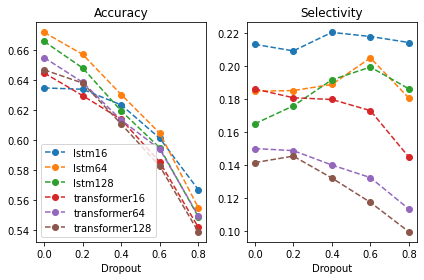

In [70]:
import matplotlib.pyplot as plt
import pickle

with open("structresults_and_models.pickle", "rb") as f:
    dd = pickle.load(f)
print(dd)
def mean_test_acc(the_dict):
    three_accs = [the_dict[z]['test_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

fig, (ax1,ax2) = plt.subplots(1,2)

for model in ['lstm', 'transformer']:
    for hidden_size in [16,64,128]:
        x_axis = [0,0.2,0.4,0.6,0.8]
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in x_axis :
            # Mean for POS task
            mean = mean_test_acc(dd['dep'][model][hidden_size][d])
            #if hidden_size > 0: mean = mean_test_acc(mlp_results['pos'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(dd['controldep'][model][hidden_size][d])
            #if hidden_size > 0: mean_control = mean_test_acc(mlp_results2['controlpos'][model][hidden_size][d])
            
            # Append
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])

        ax1.plot(x_axis, y_axis, '--o', label=model+str(hidden_size), )
        ax2.plot(x_axis, y_axis_select, '--o')
        ax1.legend()
    
ax1.set_title("Accuracy")
ax2.set_title("Selectivity")
ax1.set_xlabel("Dropout")
ax2.set_xlabel("Dropout")

plt.tight_layout()
plt.show()